# Explore, Clean the whole_play file using spark
### Then
- clean dirty data, drop outliers and unneccesary variables for churn prediction
- filter out the 'robot'/'test account' from the user
- give churn label to each valid user
- downsampling among valid user


### Import pyspark libs and initialze SparkSession

In [1]:


#sparksession is used to create DF, register DF as tables, excute SQL over tables, cache tables
from pyspark.sql import SparkSession

from pyspark.sql import Row
from pyspark.sql import functions

from pyspark.sql.functions import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

from operator import add
from operator import ge
import sys

In [2]:
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline

In [3]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [4]:
#Next, create pyspark.sql.SparkSession, which is the main entry point for DataFrame and SQL functionality
#initialize
'''
class Builder
Builder for SparkSession.

appName(name)
Sets a name for the application, which will be shown in the Spark web UI.

If no application name is set, a randomly generated name will be used.

Parameters:	name – an application name
New in version 2.0.

config(key=None, value=None, conf=None)
Sets a config option. Options set using this method are automatically propagated to both SparkConf and SparkSession‘s own configuration.

For an existing SparkConf, use conf parameter.
'''
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### Load in play_file

In [9]:
#load in date file, textFile will return RDD
rdd = sc.textFile("D:/MusicFile/all_play_1.log.fn")

In [7]:
#How many rows before modifying the format?
rdd.count()
#might take almost several mins to run

164667319

In [8]:
#take a look at the format
rdd.take(10)

['264715 \t 20170301_play.log',
 '290416 \t 20170301_play.log',
 '154422682 \tar \t20870993 \t1 \t用情 \t狮子合唱团 \t22013 \t332 \t0 \t 20170301_play.log',
 '154421907 \tip \t6560858 \t0 \t表情不要悲伤 \t伯贤&D.O.&张艺兴&朴灿烈 \t96 \t161 \t0 \t 20170301_play.log',
 "154422630 \tar \t3385963 \t1 \tBaby, Don't Cry(人鱼的眼泪) \tEXO \t235868 \t235 \t0 \t 20170301_play.log",
 '154410267 \tar \t6777172 \t0 \t3D-环绕音律1(3D Mix) \tMcTaiM \t164 \t237 \t0 \t 20170301_play.log',
 '154407793 \tar \t19472465 \t0 \t刚好遇见你 \t曲肖冰 \t24 \t201 \t0 \t 20170301_play.log',
 '154422626 \tar \t3198036 \t1 \t只唱给你听 \tSpeXial \t275249 \t0 \t0 \t 20170301_play.log',
 '154422681 \tar \t891952 \t0 \t老男孩-(电影《老男孩》主题曲) \t筷子兄弟 \t300 \t300 \t0 \t 20170301_play.log',
 '154408091 \tar \t4623962 \t0 \t预谋 许佳慧 \t网络歌手 \t243 \t243 \t0 \t 20170301_play.log']

Notice the first two rows contains nothing, at with wrong column number.
Each row is separated by "\t", with 10 fields, with some column type as float, some as string

If use **sc.read.csv(path =..., sep = "\t", schema = schema**, it will cause mislocation(spark ignore missing value and continue reading the next field as the value of this field

Also can use Pandas to load in file directly as DataFrame, using **error_bad_lines = False**, it will automatically ignore those mislocation rows, but since the whole_play file is >13G, using Pandas cost lots of time


In [7]:
#Split each row by "\t", if there are 10 fields with correct type, 
#keep them, if not, skip it, also give the col_name
def parseLine(line):
    fields = line.split("\t")
    if len(fields) == 10:
        try: 
            uid = float(fields[0])
            device = str(fields[1])
            song_id = float(fields[2])
            song_type = float(fields[3])
            song_name = str(fields[4])
            singer = str(fields[5])
            play_time = float(fields[6])
            song_length = float(fields[7])
            paid_flag = float(fields[8])
            file_name = str(fields[9])
            return Row(uid, device, song_id, song_type, song_name, singer, 
                       play_time, song_length, paid_flag, file_name)
        except:
            return Row(None)
    else:
        return Row(None)

# Create Row entries that specify column name, to prepare the RDD to convert it to a DataFrame
# Always important to filter on field length after splitting, to avoid "index out of range error"

In [8]:
# schema is like the setting parameters for each column
# Spark SQL StructType is the data type representing rows. 
# A StructType object comprises a list of StructField, which represents a field in a StructType
# StructField("col_name", dataType, nullable)


schema = StructType([StructField('uid', FloatType(), False),
                     StructField('device', StringType(), True),
                     StructField('song_id', FloatType(), False),
                     StructField('song_type', FloatType(), True),
                     StructField('song_name', StringType(), True),
                     StructField('singer', StringType(), True),
                     StructField('play_time', FloatType(), False),
                     StructField('song_length', FloatType(), True),
                     StructField('paid_flag', FloatType(), True),
                     StructField('file_name', StringType(), True),])

In [8]:
len(schema)
#only rows satisfying schema will be kept after filtering

10

In [10]:
songs = rdd.map(parseLine).filter(lambda x: len(x) == len(schema))

In [11]:
#cache means temperorily save in the memory
song_df = spark.createDataFrame(songs, schema).cache()

In [13]:
pd.DataFrame(song_df.take(10), columns=song_df.columns)

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag,file_name
0,154422688.0,ar,20870992.0,1.0,用情,狮子合唱团,22013.0,332.0,0.0,20170301_play.log
1,154421904.0,ip,6560858.0,0.0,表情不要悲伤,伯贤&D.O.&张艺兴&朴灿烈,96.0,161.0,0.0,20170301_play.log
2,154422624.0,ar,3385963.0,1.0,"Baby, Don't Cry(人鱼的眼泪)",EXO,235868.0,235.0,0.0,20170301_play.log
3,154410272.0,ar,6777172.0,0.0,3D-环绕音律1(3D Mix),McTaiM,164.0,237.0,0.0,20170301_play.log
4,154407792.0,ar,19472464.0,0.0,刚好遇见你,曲肖冰,24.0,201.0,0.0,20170301_play.log
5,154422624.0,ar,3198036.0,1.0,只唱给你听,SpeXial,275249.0,0.0,0.0,20170301_play.log
6,154422688.0,ar,891952.0,0.0,老男孩-(电影《老男孩》主题曲),筷子兄弟,300.0,300.0,0.0,20170301_play.log
7,154408096.0,ar,4623962.0,0.0,预谋 许佳慧,网络歌手,243.0,243.0,0.0,20170301_play.log
8,154422576.0,ar,703750.0,0.0,爸爸妈妈听我说,儿童歌曲,207.0,207.0,0.0,20170301_play.log
9,154417312.0,ar,6491500.0,0.0,Stereo Love,Edward Maya,56.0,184.0,0.0,20170301_play.log


### Inspect the play.log

In [12]:
song_df.dtypes

[('uid', 'float'),
 ('device', 'string'),
 ('song_id', 'float'),
 ('song_type', 'float'),
 ('song_name', 'string'),
 ('singer', 'string'),
 ('play_time', 'float'),
 ('song_length', 'float'),
 ('paid_flag', 'float'),
 ('file_name', 'string')]

In [ ]:
#song_df.describe().show()
#Not enough space to cache....

The file size is too large, so the thing before we actually explore other columns is shrink file size based on the most important columns(uid, device, play_time, song_length, file_name)

Drop column(song_type, song_name, singer, paid_flag)

### Extracting & Exploring & Cleaning
Since we are focusing on user churn analysis and prediction, the information about song, singer are useless right now, so drop those columns to shrink the file size

Filter rows with incorrect records
i.e.
some user has extremely high number of play counts;
too long play_time; negative play_time/song_length
#### Impute son_length

In [13]:
# as noticed at One_file_explore, there might be negative song_length, play_time, 
#drop them, impute song_length with play time
song_df = song_df.filter(song_df.play_time >=0) \
                .filter(song_df.song_length >0) \
                .dropna(how = 'any', subset = ['play_time']).cache()


In [19]:
#take a look at play_time and song_length
song_df.select('play_time', 'song_length').describe().show()


+-------+--------------------+------------------+
|summary|           play_time|       song_length|
+-------+--------------------+------------------+
|  count|           139711287|         139711287|
|   mean|  204256.21820355425|308.64432725864117|
| stddev|5.3620264507477504E8|167713.64520210458|
|    min|                 0.0|               1.0|
|    max|        1.4934674E12|      1.34396621E9|
+-------+--------------------+------------------+



In [17]:
#Check uid>>take so much time to run...
uid_count = song_df.groupBy('uid').count().orderBy('count',ascending = False)
uid_count.show()

+------------+-------+
|         uid|  count|
+------------+-------+
|   1685126.0|3537754|
| 3.7025504E7|3290924|
|   1791497.0|2992986|
|    497685.0|2496827|
|    736305.0|1741557|
|    751824.0|1663395|
|   1062806.0|1160654|
|         0.0| 759309|
|   1749320.0| 414280|
| 2.8638488E7| 402177|
| 4.6532272E7| 402150|
|   1679121.0| 379672|
|    637650.0| 211764|
| 6.4268008E7| 141533|
| 3.2166204E7| 127948|
| 1.5594824E8| 115974|
| 2.6036032E7|  95701|
|1.67982848E8|  82605|
|    533817.0|  77965|
| 1.6517426E7|  68340|
+------------+-------+
only showing top 20 rows



According to the groupby result, there are some users' records seem abnormal, either with extremely large play times, or total_play_length. Based on Statistical domain knowledge and business sense, these users might be **test account, robot, or account for special function**, so those can be viewed as outliers, do little help for us to analyze real user's behavior. So we truncate user by how many songs they played totally during this period try**95%**(almost +-2sigma)?.

or common assumption: average song_length = 4min, a user play at most 10 hours a day, so the total play_time for one day is 150, from March 1st to May 12th(drop March 2nd to March 29th), there are 45 days, so the total play time is 5400. That might be the uppper bound for normal user at MusicBox. 

**Notice: according to the tutor, 95% might be too conservative, maybe try 98%**

#### Detect Outliers and clean them

In [23]:
#How many users during this period?
song_df.select('uid').distinct().count()

141644

In [169]:
uid_count.count()

141644

In [23]:
count_ceiling = uid_count.approxQuantile('count', [0.98],0)
print('98 percentile of user play time is {:0}'.format(count_ceiling[0]))
#try 0.98?

95 percentile of user play time is 3904.0


In [18]:
#try <5400
count_ceiling_1 = uid_count.filter(uid_count['count'] <= 5400)
count_ceiling_1.count()/141644

0.9928765072999916

### if use 2sigma to drop outlier, the max play_time is 3904, if use our assumption 5400, only 0.08% will be treated as outlier. In this situation, I will follow drop 0.08%.

In [19]:
uid_count.printSchema()
valid_uid = count_ceiling_1.cache()
# .toPandas() removed,  for join df purpose below
valid_uid.take(10)

root
 |-- uid: float (nullable = false)
 |-- count: long (nullable = false)



[Row(uid=168392096.0, count=5399),
 Row(uid=168531584.0, count=5398),
 Row(uid=168281952.0, count=5394),
 Row(uid=168373024.0, count=5392),
 Row(uid=168203056.0, count=5391),
 Row(uid=168345696.0, count=5388),
 Row(uid=168607088.0, count=5387),
 Row(uid=168111184.0, count=5384),
 Row(uid=168947008.0, count=5382),
 Row(uid=168318656.0, count=5381)]

In [33]:
print("number of valid users = {0:0}, \n number of valid plays = {1:.2e}"
      .format(valid_uid.count(), valid_uid["count"].sum()))


TypeError: 'Column' object is not callable

In [34]:
#save valid uid
valid_uid.repartition(1).write.csv('D:/MusicFile/valid_uid_316', header=True)

In [35]:
valid_uid.count()

140635

In [38]:
valid_uid.dtypes

[('uid', 'float'), ('count', 'bigint')]

### The following valid_uid is shared by my teammates, these file maybe different with mine.
My valid_uid is 134563, hers is 135426. But that is OK

In [17]:
valid_uid_teammates = pd.read_csv("D:/MusicFile/valid_uid_zw.csv")
print(valid_uid_teammates.dtypes)
valid_uid_teammates.head()

uid    float64
dtype: object


,uid
0,13600000.0
1,16800000.0
2,22000000.0
3,23200000.0
4,23900000.0


In [158]:
#how many valid_user of my teammate's?
valid_uid_teammates.count()

135426

#### Join valid uid, with song_df of necessary columns

In [14]:
valid_uid = pd.read_csv("D:/MusicFile/valid_uid/valid_uid_new.csv")
sv = StructType([StructField('uid', FloatType(), False),
                 StructField('count', IntegerType(), False)])
valid_uid = spark.createDataFrame(valid_uid, sv).cache()

In [15]:
song_valid_df = song_df.join(valid_uid, on = 'uid', how = 'inner') \
                       .select('uid', 'device', 'song_id', 'song_type','play_time', 'song_length', 'file_name') \
                    .cache()

In [16]:
song_valid_df.show()

+-----------+------+---------+---------+---------+-----------+--------------------+
|        uid|device|  song_id|song_type|play_time|song_length|           file_name|
+-----------+------+---------+---------+---------+-----------+--------------------+
|1.3586118E7|    ar| 157799.0|      0.0|     31.0|      258.0| 20170330_3_play.log|
|1.3586118E7|    ar|9561562.0|      0.0|      6.0|      253.0| 20170330_3_play.log|
|1.3586118E7|    ar| 237843.0|      0.0|      4.0|      210.0| 20170330_3_play.log|
|1.3586118E7|    ar|9561562.0|      0.0|      0.0|      253.0| 20170330_3_play.log|
|1.3586118E7|    ar|9561562.0|      0.0|      4.0|      253.0| 20170330_3_play.log|
|1.3586118E7|    ar| 157671.0|      0.0|      1.0|      203.0| 20170330_3_play.log|
|1.3586118E7|    ar| 157671.0|      0.0|      0.0|      203.0| 20170330_3_play.log|
|1.3586118E7|    ar| 157671.0|      0.0|      1.0|      203.0| 20170330_3_play.log|
|1.3586118E7|    ar| 157719.0|      0.0|    237.0|      237.0| 20170330_3_pl

In [22]:
song_valid_df.count()

137975112

In [22]:
song_valid_df.select('uid').distinct().count()

140635

Filtered whole_play.log by valid uid, we can now see there are 137975112 play records now. Compared to 164667319, almost **16%** is dropped. Which is acceptable, since we drop 5% users, and those users are responsible for 16% play records.
Now, extract the date information so that we can analysis the trends and patterns of user behavior.
#### Clean file name, get time feature

In [17]:

song_valid_df2 = song_valid_df.withColumn("device", trim(song_valid_df.device)) \
                               .withColumn('date_str', trim(song_valid_df.file_name.substr(1,9))) \
                               .withColumn('date_string', regexp_replace('date_str', '20170339', '20170329')) \
                               .withColumn("unix_date", unix_timestamp('date_string', 'yyyyMMdd')) \
                               .withColumn("date", from_unixtime('unix_date').cast(DateType())) \
                               .drop('date_str') \
                               .drop('date_string') \
                               .drop('unix_date')
                               
#.withColumn means adding columns
#trim() truncate blanks, which is a sql function
#change string to date: detect incorrect record, replace it. then 

In [ ]:
#way to deal with date variable
add_date = song_valid_df.withColumn('date_str', trim(song_valid_df.file_name).substr(1,9)) \ 
                        .withColumn('date_string', regexp_replace('date_str', '20170339', '20170329')) \
                        .withColumn('date', from_unixtime(unix_timestamp('date_string', 'yyyyMMdd')) \
                                    .alias("date").cast(DateType()))

Although we filtered incorrect format rows when we parseLine the entire file, each fields also contains blank at the head and end, for example, device, and file_name. So truncate them first in order to detect them more accurately.


In [18]:
pd.DataFrame(song_valid_df2.take(10), columns = song_valid_df2.columns)

,uid,device,song_id,song_type,play_time,song_length,file_name,date
0,13586118.0,ar,157799.0,0.0,31.0,258.0,20170330_3_play.log,2017-03-30
1,13586118.0,ar,9561562.0,0.0,6.0,253.0,20170330_3_play.log,2017-03-30
2,13586118.0,ar,237843.0,0.0,4.0,210.0,20170330_3_play.log,2017-03-30
3,13586118.0,ar,9561562.0,0.0,0.0,253.0,20170330_3_play.log,2017-03-30
4,13586118.0,ar,9561562.0,0.0,4.0,253.0,20170330_3_play.log,2017-03-30
5,13586118.0,ar,157671.0,0.0,1.0,203.0,20170330_3_play.log,2017-03-30
6,13586118.0,ar,157671.0,0.0,0.0,203.0,20170330_3_play.log,2017-03-30
7,13586118.0,ar,157671.0,0.0,1.0,203.0,20170330_3_play.log,2017-03-30
8,13586118.0,ar,157719.0,0.0,237.0,237.0,20170330_3_play.log,2017-03-30
9,13586118.0,ar,237843.0,0.0,210.0,210.0,20170330_3_play.log,2017-03-30


In [19]:
song_cleaned_df = song_valid_df2.drop('file_name').cache()
pd.DataFrame(song_cleaned_df.take(10), columns = song_cleaned_df.columns)

,uid,device,song_id,song_type,play_time,song_length,date
0,13586118.0,ar,157799.0,0.0,31.0,258.0,2017-03-30
1,13586118.0,ar,9561562.0,0.0,6.0,253.0,2017-03-30
2,13586118.0,ar,237843.0,0.0,4.0,210.0,2017-03-30
3,13586118.0,ar,9561562.0,0.0,0.0,253.0,2017-03-30
4,13586118.0,ar,9561562.0,0.0,4.0,253.0,2017-03-30
5,13586118.0,ar,157671.0,0.0,1.0,203.0,2017-03-30
6,13586118.0,ar,157671.0,0.0,0.0,203.0,2017-03-30
7,13586118.0,ar,157671.0,0.0,1.0,203.0,2017-03-30
8,13586118.0,ar,157719.0,0.0,237.0,237.0,2017-03-30
9,13586118.0,ar,237843.0,0.0,210.0,210.0,2017-03-30


In [154]:
song_cleaned_df.count()

137975112

### Create Churn Label
Using records from 2017-03-01 to 2017-05-12 as train/test dataset, the last two week(2017-04-29~ 2017-05-12) as churn window, which means if user show no activity during the last two weeks, then we label them as Churn user.

**Potential idea about how to define churn**
1. According to their average play time trend(increasing, decreasing, stable)
2. Maybe "reduce 80% play_time within 2-week" instead of "totally non-active"
3. Since we have other information such as search.log, download.log, combine them together to see the churn condition << Inspired by RFM model, we can weighted score play, download, search by quantile, higher score means more active user, lower score means large possibility of churn.

Active user is the one who has play record during the last two week, non-record user are labeled as churn

In [44]:
active_uid = song_cleaned_df.filter(song_cleaned_df.date >= '2017-04-29') \
                           .select(song_cleaned_df.uid.alias('active_uid')) \
                           .distinct()


In [48]:
#valid_uid.count() 146035
active_uid.count()

89216

In [45]:
#save the active_uid
active_uid.repartition(1).write.csv("D:/MusicFile/active_uid", header = True)

#### Add label

In [46]:
uid_label = active_uid.join(valid_uid, valid_uid.uid == active_uid.active_uid, "left_outer")
uid_label = uid_label.withColumn('Churn', uid_label.active_uid.isNull().astype(IntegerType())).cache()

In [49]:
pd.DataFrame(uid_label.take(5), columns = uid_label.columns)

,uid,count,active_uid,Churn
0,13586118.0,445,NaN,1
1,16844004.0,2,NaN,1
2,22030996.0,186,22030996.0,0
3,23232528.0,1,NaN,1
4,23885908.0,42,NaN,1


In [50]:
#drop count and active_uid
uid_label = uid_label.drop('count').drop('active_uid')

In [51]:
#save the output, so that later when continuing work, just read in this csv
uid_label.select('uid', 'Churn').repartition(1).write.csv("D:/MusicFile/uid_label_new", header = True)

### Downsampling
Aim: shrink file size, balance churn/active precentage
Method: randomly select 5% from uid(with churn label), according to the original churn/active rate: 5/8

In [20]:
uid_label = pd.read_csv("D:/MusicFile/uid_label_new.csv")
#convert into spark dataframe
sv = StructType([StructField('uid', FloatType(), False),
                 StructField('churn', IntegerType(), False)])
uid_label = spark.createDataFrame(uid_label, sv).cache()

In [46]:
print(uid_label.dtypes)

[('uid', 'float'), ('churn', 'int')]


In [27]:
pd.DataFrame(uid_label.take(10), columns = uid_label.columns)

,uid,churn
0,13586118.0,1
1,16844004.0,1
2,22030996.0,0
3,23232528.0,1
4,23885908.0,1
5,32366964.0,1
6,32962054.0,0
7,36249280.0,1
8,39197032.0,1
9,39567468.0,0


In [52]:
uid_label.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|51419|
|    0|89216|
+-----+-----+



In [53]:
print("Active/Churn:", 89216/51419)

Active/Churn: 1.735078472938019


There are 8/5 active user/churn user, which is not that balance, applying downsampling technique to balance positive/negative and reduce file size.
![Image of Downsampling]("D:/MusicFile/downsampling.PNG)

Now, since we are the first time, downsample to around 5%

In [60]:
sampled_uid = uid_label.sampleBy('Churn', fractions = {1:0.086, 0:0.05})
sampled_uid.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 4358|
|    0| 4504|
+-----+-----+



In [198]:
sampled_uid = sampled_uid.select('uid', "Churn")

### Summary of the amount change of user
**original user** is 141644 <p>↓  
**valid user** is 140635 with **active user** 89216, **churn user** 51419<p>↓  
**downsampled user** is 8862, with **active** 4504, **churn** 4358

In [22]:
sampled_uid = pd.read_csv("D:/MusicFile/sampled_uid_8862.csv")
su = StructType([StructField('uid', FloatType(), False)])
sampled_uid = spark.createDataFrame(sampled_uid, su).cache()

In [41]:
sample_uid_label = sampled_uid.join(uid_label, sampled_uid.uid == uid_label.uid, how = 'left') \
                              .drop(sampled_uid.uid) \
                              .cache()

In [42]:
pd.DataFrame(sample_uid_label.take(5), columns = sample_uid_label.columns)

,uid,churn
0,154422848.0,1
1,154489312.0,1
2,154502640.0,1
3,154504752.0,1
4,154570608.0,1


In [43]:
sample_uid_label.dtypes

[('uid', 'float'), ('churn', 'int')]

In [44]:
sample_uid_label.count()

8862

In [62]:
(4358+4504)/140635
#1.735*0.05

0.06301418565790877

In [45]:
#save sample_uid_label
sample_uid_label.repartition(1).write.csv('D:/MusicFile/sample_uid_label', header=True)

Now, we sampled 8862 user as around 50% from churn, 50% from active, which is 6% of the original user pool. The following analysis and predictive model building will be based on these sampled user.

## Extract all records(play, search, download) of sampled user
Using join to filter play.log of sampled user from the original cleaned play_df, then check how those sampled user acted during the entire period


In [205]:
from pyspark.sql.functions import datediff, to_date, lit
date_diff = pd.to_datetime('2017-05-12') - pd.to_datetime("2017-03-01")
date_diff

Timedelta('72 days 00:00:00')

In [134]:
#check the date.dtype
#song_valid_df2.schema
#song_valid_df2.show(10)
song_valid_df2.select("date").show(10)
#why column is not callable?? Pyspark is not like python, using select
#song_valid_df2.date.show()

+----------+
|      date|
+----------+
|2017-03-01|
|2017-03-01|
|2017-03-01|
|2017-03-01|
|2017-03-01|
|2017-03-01|
|2017-03-01|
|2017-03-01|
|2017-03-01|
|2017-03-01|
+----------+
only showing top 10 rows



# need to do the next code

In [47]:

#from operator import ge
#s_date = "2017-03-01"
#e_date = "2017-04-29"
#date_end = to_date(date).cast(TimestampType())
#before churn window
sample_play = song_cleaned_df.filter(song_cleaned_df["date"] < "2017-04-29").join(sample_uid_label, sample_uid_label.uid == song_cleaned_df.uid, how = 'inner') \
                            .drop(sample_uid_label.uid) \
                            .cache()

In [48]:
#sample_play involves log data before 2017-04-29
sample_play.count()

4955455

In [67]:
#in entire period
sampled_play = song_cleaned_df.join(sampled_uid, sampled_uid.uid == song_cleaned_df.uid, how = 'inner') \
                            .drop(sampled_uid.uid) \
                            .cache()
#done 3/7

In [66]:
#including 2017--12, there are 180000 more records
sampled_play.count()

6118322

In [50]:
sample_play = sample_play.drop('song_type')
pd.DataFrame(sample_play.take(10), columns = sample_play.columns)

,uid,device,song_id,play_time,song_length,date,churn
0,49423096.0,ar,203139.0,204.0,270.0,2017-04-02,0
1,49423096.0,ar,133946.0,165.0,286.0,2017-04-02,0
2,49423096.0,ar,380389.0,40.0,233.0,2017-04-02,0
3,49423096.0,ar,23534240.0,115.0,378.0,2017-04-02,0
4,49423096.0,ar,6672344.0,69.0,249.0,2017-04-02,0
5,49423096.0,ar,6769715.0,123.0,124.0,2017-04-02,0
6,49423096.0,ar,6989315.0,80.0,84.0,2017-04-02,0
7,49423096.0,ar,7175883.0,138.0,139.0,2017-04-02,0
8,49423096.0,ar,7353175.0,6.0,123.0,2017-04-02,0
9,49423096.0,ar,921642.0,5.0,243.0,2017-04-02,0


In [203]:
##RUN IT DURING SLEEP!!! COST FOREVER
#check again of the dataset to make sure every column has no missing value, outliters
sampled_play.describe().show()

+-------+-------+--------------------+------------------+-----------------+--------------------+-------------------+
|summary| device|             song_id|         play_time|      song_length|                 uid|              Churn|
+-------+-------+--------------------+------------------+-----------------+--------------------+-------------------+
|  count|2852352|             2852352|           2852352|          2852352|             2852352|            2852352|
|   mean|   null|1.022984193691201E14|1596.9657751442098|270.6672415878897|1.6314567413960478E8|  0.276720755362592|
| stddev|   null| 2.83027760288859E16|30606.474290019458|306.6561443148601|  1.63940429026185E7|0.44737730058985425|
|    min|     ar|                -1.0|               0.0|              1.0|             12333.0|                  0|
|    max|     ip|        1.8446744E19|       2.8639388E7|          23978.0|        1.69258736E8|                  1|
+-------+-------+--------------------+------------------+-------

## sampled_play including 5-12, sample_play till 4-29
### save the sampled_play as csv, so when building prediction model, it can be used directly

In [69]:
sampled_play.repartition(1).write.csv("D:/MusicFile/sampled_play", header = True)

In [51]:
sample_play.repartition(1).write.csv("D:/MusicFile/sample_play_new316", header = True)

### Some queries about how user behavior changed along with the date

In [204]:
#top 20 dates with largest play_records?
sampled_play.groupBy("date").count().orderBy('count').show(80)

+----------+------+
|      date| count|
+----------+------+
|2017-04-24| 22299|
|2017-05-05| 30571|
|2017-05-09| 31077|
|2017-05-04| 31510|
|2017-05-11| 32236|
|2017-04-14| 32495|
|2017-05-12| 32625|
|2017-05-10| 32811|
|2017-04-11| 33206|
|2017-05-07| 33623|
|2017-05-08| 33835|
|2017-05-02| 34280|
|2017-05-06| 34608|
|2017-05-03| 35531|
|2017-05-01| 36560|
|2017-04-29| 37319|
|2017-04-30| 38588|
|2017-04-20| 39306|
|2017-04-28| 39871|
|2017-04-26| 40011|
|2017-04-25| 40048|
|2017-04-18| 40951|
|2017-04-27| 41910|
|2017-04-21| 42095|
|2017-04-22| 42301|
|2017-03-29| 42732|
|2017-04-23| 43752|
|2017-04-19| 43823|
|2017-03-09| 44774|
|2017-04-17| 46903|
|2017-03-08| 47363|
|2017-03-07| 47799|
|2017-04-16| 49121|
|2017-04-15| 50028|
|2017-04-13| 50572|
|2017-04-03| 53748|
|2017-03-06| 53969|
|2017-04-12| 54118|
|2017-04-10| 54313|
|2017-04-09| 57961|
|2017-03-05| 58414|
|2017-04-07| 63077|
|2017-03-04| 63323|
|2017-04-05| 63606|
|2017-04-06| 64061|
|2017-04-08| 64975|
|2017-03-03| 67131|


In [206]:
#from 2017-03-01 to 2017-04-29, what's the play trend?
sampled_play.groupBy("date").count().orderBy('date').show(80)

+----------+------+
|      date| count|
+----------+------+
|2017-03-01|140920|
|2017-03-02| 96004|
|2017-03-03| 67131|
|2017-03-04| 63323|
|2017-03-05| 58414|
|2017-03-06| 53969|
|2017-03-07| 47799|
|2017-03-08| 47363|
|2017-03-09| 44774|
|2017-03-29| 42732|
|2017-03-30|104881|
|2017-03-31|142185|
|2017-04-01|110660|
|2017-04-02| 97482|
|2017-04-03| 53748|
|2017-04-04| 84990|
|2017-04-05| 63606|
|2017-04-06| 64061|
|2017-04-07| 63077|
|2017-04-08| 64975|
|2017-04-09| 57961|
|2017-04-10| 54313|
|2017-04-11| 33206|
|2017-04-12| 54118|
|2017-04-13| 50572|
|2017-04-14| 32495|
|2017-04-15| 50028|
|2017-04-16| 49121|
|2017-04-17| 46903|
|2017-04-18| 40951|
|2017-04-19| 43823|
|2017-04-20| 39306|
|2017-04-21| 42095|
|2017-04-22| 42301|
|2017-04-23| 43752|
|2017-04-24| 22299|
|2017-04-25| 40048|
|2017-04-26| 40011|
|2017-04-27| 41910|
|2017-04-28| 39871|
|2017-04-29| 37319|
|2017-04-30| 38588|
|2017-05-01| 36560|
|2017-05-02| 34280|
|2017-05-03| 35531|
|2017-05-04| 31510|
|2017-05-05| 30571|


In [228]:
churn_playtime = sampled_play.groupBy(sampled_play.Churn) \
             .agg(func.avg('play_time'), func.sum("play_time"), func.min("play_time"),func.max("play_time"))
churn_playtime.show()


+-----+------------------+--------------------+--------------+--------------+
|Churn|    avg(play_time)|      sum(play_time)|min(play_time)|max(play_time)|
+-----+------------------+--------------------+--------------+--------------+
|    1| 2838.889162910153|2.2407494107307982E9|           0.0|   2.8639388E7|
|    0|1121.8159896179477| 2.314359111933338E9|           0.0|   2.2684604E7|
+-----+------------------+--------------------+--------------+--------------+



AttributeError: 'DataFrame' object has no attribute 'bar'

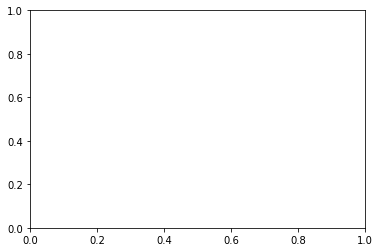

In [235]:
fig = plt.figure()
ax = fig.add_subplot(111)
churn_playtime.columns
churn_playtime.bar(x = "Churn", y = ['avg(play_time)', 'sum(play_time)', 'min(play_time)', 'max(play_time)'])

In [222]:
churn_songlength = sampled_play.groupBy(sampled_play.Churn) \
                               .agg(func.avg('song_length'), func.sum("song_length"), func.min("song_length"),func.max("song_length"))
churn_songlength.show()    

+-----+------------------+--------------------+----------------+----------------+
|Churn|  avg(song_length)|    sum(song_length)|min(song_length)|max(song_length)|
+-----+------------------+--------------------+----------------+----------------+
|    1|269.10882532989916|2.1240894137701607E8|             1.0|         19732.0|
|    0| 271.2634789709998| 5.596293065006843E8|             1.0|         23978.0|
+-----+------------------+--------------------+----------------+----------------+



Clearly we can see there are large difference between churn/active user about play_time and song_length. Active user spend twice average play time than churn user, 

In [71]:
sampled_play.crosstab('churn', 'device').show()

+------------+-------+------+
|churn_device|     ar|    ip|
+------------+-------+------+
|           1|1099765|220193|
|           0|3928343|870021|
+------------+-------+------+



In [ ]:
spark.stop()